# Predict Housing Price

**Guidance**: 
1. Perform hyperparameter tuning on the best performing models from Part 2. But be careful! Depending on how you preprocessed your data, you may not be able to use the default Scikit-Learn functions without leaking information. You'll find some helpful starter docstrings in the 3 - tuning_pipeline.ipynb notebook.
2. Save your tuned model - you may want to create a new models/ directory in your repo
3. Build a pipeline that performs your preprocessing steps and makes predictions using your tuned model for new data - assume the new data is in the same JSON format as your original data.
4. Save your final pipeline

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import joblib
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

from functions_visualization import def_Plot_Actual_vs_Predicted
from functions_modelling import def_Custom_Hyperparameter_Search, MedianTargetEncoder, def_Make_Prediction_Housing_Price

import warnings
warnings.filterwarnings("ignore")

## 1. Hyperparameter tuning on the best performing models from Part 2 (Random Forest and XGBoost)

### Prepare data

In [2]:
# Load data

X_train = pd.read_csv('../data/csv_files/X_train_transformed.csv')  # scaled, formatted
y_train = pd.read_csv('../data/csv_files/y_train.csv')  
X_test = pd.read_csv('../data/csv_files/X_test_transformed.csv')    # scaled, formatted
y_test = pd.read_csv('../data/csv_files/y_test.csv')       

In [3]:
# Check shape
X_train.shape , X_test.shape , y_train.shape , y_test.shape

((907, 31), (227, 31), (907, 1), (227, 1))

In [4]:
### Combine training data
training_set = pd.concat([X_train, y_train], axis=1)

training_set.head()
print(training_set.shape)

(907, 32)


In [5]:
# training_set.columns

## XGBoost

In [6]:
###### XGBOOST
# Define hyperparameter values 
param_grid = {
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 500],
    'subsample': [0.6, 0.8, 1],
    'colsample_bytree': [0.6, 0.8, 1],
    'gamma': [0, 0.1, 0.5, 1, 5]
}

# Find the best hyperparameters
from xgboost import XGBRegressor
best_params_XG = def_Custom_Hyperparameter_Search(training_set, param_grid, XGBRegressor)

print("Best parameters for XGBoost:\n")
best_params_XG

Best parameters for XGBoost:



{'max_depth': 3,
 'learning_rate': 0.1,
 'n_estimators': 500,
 'subsample': 0.8,
 'colsample_bytree': 0.6,
 'gamma': 0}

In [7]:
# Train final XGBoost with the best hyperparameters
final_model_XG = XGBRegressor(**{'max_depth': 3,
 'learning_rate': 0.1,
 'n_estimators': 500,
 'subsample': 0.8,
 'colsample_bytree': 0.8,
 'gamma': 0}, random_state=142)
final_model_XG.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=142, ...)

In [8]:
# Model evaluation
print('    - R^2 of testing data:', final_model_XG.score(X_test, y_test))
print('    - R^2 of training data:', final_model_XG.score(X_train, y_train))
print("    - Mean Absolute Error on testing data: ", mean_absolute_error(y_test, final_model_XG.predict(X_test))) # y_test, y_pred

    - R^2 of testing data: 0.8262382013861573
    - R^2 of training data: 0.9755218255559398
    - Mean Absolute Error on testing data:  56146.874389110686


#### Comment: The tuned model achieving 82.6% is higher than its own baseline model result in Part 2 (81.3%), and the MAE decreases from 57,112 to 56,146 dollars.

## Random Forest

In [9]:
###### RANDOM FOREST
# Define hyperparameter values for Random Forest
param_grid = {
    'n_estimators': [200, 300, 500],
    'max_depth': [None, 10, 30, 50],
    'max_features': [None, 'sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Find the best hyperparameters for Random Forest
from sklearn.ensemble import RandomForestRegressor
best_params_RD = def_Custom_Hyperparameter_Search(training_set, param_grid, RandomForestRegressor)

print("Best parameters for Random Forest:\n")
best_params_RD

Best parameters for Random Forest:



{'n_estimators': 300,
 'max_depth': 50,
 'max_features': None,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'bootstrap': True}

In [10]:
# Train final Random Forest model with the best hyperparameters
final_model_RD = RandomForestRegressor(**best_params_RD, random_state=142)
final_model_RD.fit(X_train, y_train)

RandomForestRegressor(max_depth=50, max_features=None, n_estimators=300,
                      random_state=142)

In [11]:
# Model evaluation
print('    - R^2 of testing data:', final_model_RD.score(X_test, y_test))
print('    - R^2 of training data:', final_model_RD.score(X_train, y_train))
print("    - Mean Absolute Error on testing data: ", mean_absolute_error(y_test, final_model_RD.predict(X_test))) # y_test, y_pred

    - R^2 of testing data: 0.7935836356546185
    - R^2 of training data: 0.9617360028896299
    - Mean Absolute Error on testing data:  59669.83080763583


#### Comment: The tuned model achieving 79.4% is the same as its own baseline model result in Part 2 (79.6%), and the MAEs are not different(59,564 and 59,669 dollars). Moreover, performance of this tuned Random Forest is not good as the tuned XGBoost model above.

## Linear Regression

In [12]:
###### LINEAR REGRESSION
# Define hyperparameter values for Linear Regression
param_grid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False]
}

# Find the best hyperparameters for Linear Regression
from sklearn.linear_model import LinearRegression
best_params_LR = def_Custom_Hyperparameter_Search(training_set, param_grid, LinearRegression)

print("Best parameters for Linear Regression:\n")
best_params_LR

Best parameters for Linear Regression:



{'fit_intercept': False, 'copy_X': True}

In [13]:
# Train final Linear Regression model with the best hyperparameters
final_model_LR = LinearRegression(**best_params_LR)
final_model_LR.fit(X_train, y_train)

LinearRegression(fit_intercept=False)

In [14]:
# Model evaluation
print('    - R^2 of testing data:', final_model_LR.score(X_test, y_test))
print('    - R^2 of training data:', final_model_LR.score(X_train, y_train))
print("    - Mean Absolute Error on testing data: ", mean_absolute_error(y_test, final_model_LR.predict(X_test))) # y_test, y_pred

    - R^2 of testing data: 0.7505425368297134
    - R^2 of training data: 0.7193100856108807
    - Mean Absolute Error on testing data:  71914.94623984324


#### Comment: The tuned model achieving 75% is the same as its own baseline model result in Part 2 (75%), and the MAEs are not different(71,915 and 71,915 dollars). Actually, this tuned model is the same in part 2 because Linear Regression does not have too much parameters to tune. Overally, performance of this tuned Linear Regreesion is not good as the tuned XGBoost model above.

We also tried to expand the size of parameter grid for searching the best set of parameters, but result does not improved.

====> Based on the results above, **`XGBoost` is the best-performing model.** 

In [15]:
final_model = final_model_XG

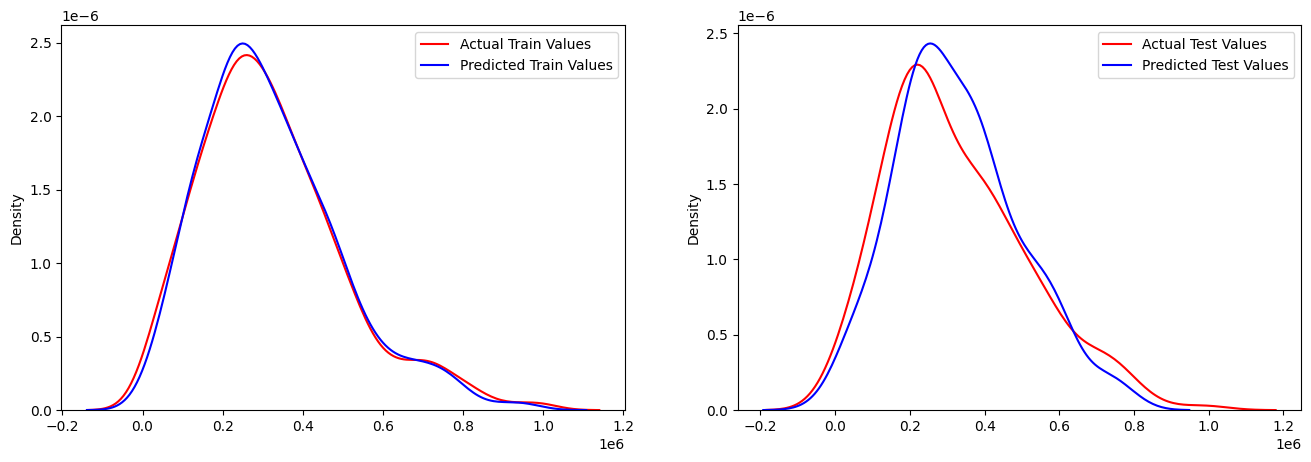

In [16]:
# Visualization
def_Plot_Actual_vs_Predicted(final_model, y_train, y_test, X_train, X_test)

## 2. Save the best model

In [17]:
# Create folder 'models' if it doesn't exist
import os
if not os.path.exists('../models'):
    os.makedirs('../models')

# Save
import joblib
joblib.dump(final_model, '../models/final_model.pkl')

['../models/final_model.pkl']

## 3. Build ultimate prediction pipeline 
* Pipeline includes preprocessing steps, loading tuned model and making predictions for new data.

#### Build pipeline

In [18]:
######## Load tuned model that was saved
final_model = joblib.load('../models/final_model.pkl')

######## Define numerical and categorical variables needed transformation
numerical_cols_X = ['latitude', 'longitude', 'year_built', 'lot_sqft', 'living_sqft']
nominal_cols = ['type']
median_encoded_cols = ['state', 'city']

######## Build pipelines for each transformation
# Pipeline for Median Target Encoding
median_target_encoding_pipeline = Pipeline(steps=[
    ('median_target_encoder', MedianTargetEncoder(columns=median_encoded_cols)),
    # ('imputer', SimpleImputer(strategy='median')),   # to handle missing values after mapping
    ('scaler', StandardScaler())
])

# Pipeline for numerical variables
numerical_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Pipeline for categorical variables
nominal_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder())
])

# Combine all pipelines with ColumnTransformer
full_pipeline = ColumnTransformer(
    transformers=[
        ('median_target_encoding', median_target_encoding_pipeline, median_encoded_cols),
        ('numerical', numerical_pipeline, numerical_cols_X),
        ('nominal', nominal_pipeline, nominal_cols)
    ],
    remainder='passthrough'  # Keep other columns unchanged
)

# Create the final prediction pipeline
prediction_pipeline = Pipeline(steps=[
        ('preprocessor', full_pipeline),
        ('model', final_model)
])

######## Prepare data
X = pd.read_csv('../data/csv_files/cleaned_data_REDUCED_outliers.csv').drop(columns='sale_price')
y = pd.read_csv('../data/csv_files/cleaned_data_REDUCED_outliers.csv')['sale_price']

######## Fit the pipeline
prediction_pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('median_target_encoding',
                                                  Pipeline(steps=[('median_target_encoder',
                                                                   MedianTargetEncoder(columns=['state',
                                                                                                'city'])),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['state', 'city']),
                                                 ('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['latitude', 'longitude',
                                                   'year_built', 'lot...
                              feature_types=None, gamma=0, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=500, n_jobs=None,
                              num_parallel_tree=None, random_state=142, ...))])

#### Save final pipeline

In [19]:
# Save the fitted pipeline
joblib.dump(prediction_pipeline, '../models/final_prediction_pipeline.pkl')

['../models/final_prediction_pipeline.pkl']

#### Check if pipeline works correctly

In [20]:
# Use the first 5 rows of data to make prediction by using pipeline that was built
predictions = prediction_pipeline.predict(X.iloc[0:5,:])
print(predictions)

[192100.8   98074.87 129787.41  98650.76 152400.02]


In [21]:
y[0:5]   # y_true

0    129900.0
1     88500.0
2    145000.0
3     65000.0
4    169000.0
Name: sale_price, dtype: float64

## 4. Implement prediction on new data

In [22]:
#  Pretend new data as the original data
data_need_prediction = pd.read_csv('../data/csv_files/cleaned_data_REDUCED_outliers.csv').drop(columns='sale_price').iloc[10:16,:]

# Make predictions
predictions = def_Make_Prediction_Housing_Price(data_need_prediction)
predictions

array([165302.  ,  40323.44, 302889.3 , 149263.19, 185443.3 , 129817.17],
      dtype=float32)

In [23]:
y_true = pd.read_csv('../data/csv_files/cleaned_data_REDUCED_outliers.csv')['sale_price'][10:16]
y_true

10    149900.0
11     45000.0
12    310000.0
13    147000.0
14    195000.0
15    136000.0
Name: sale_price, dtype: float64